# 1 - Image Segmentation with U-Net

Image Segmentation is similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class.

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center><font color="purple"><u><b>Figure 1</b></u>: Example of a segmented image <br></font></center></caption>

In [1]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

%matplotlib inline

## 2 - Data Manipulation

### 2.1 - Load Data

In [3]:
path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')

image_list_orig = os.listdir(image_path)

image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

In [4]:
print(f"RGB Images: {len(image_list)}")
print(f"Masked Images: {len(mask_list)}")

RGB Images: 1060
Masked Images: 1060


Text(0.5, 1.0, 'Segmentation')

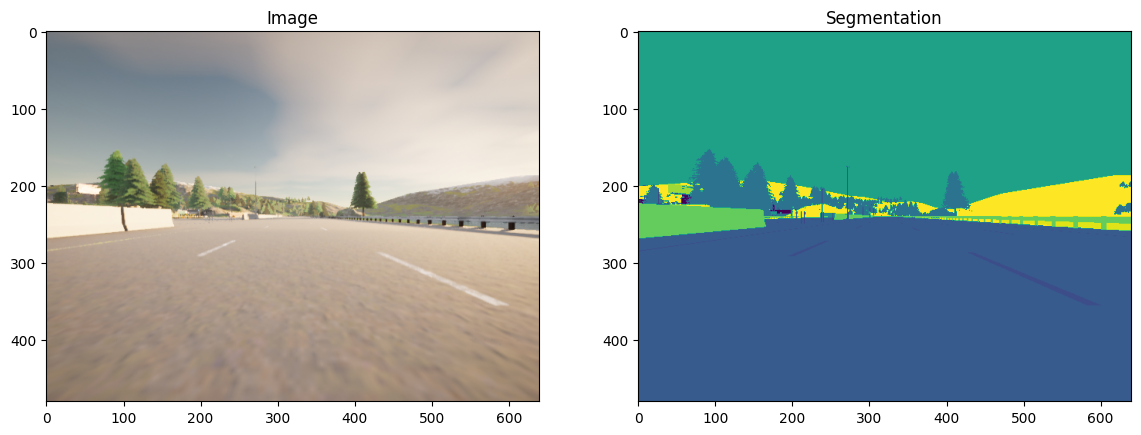

In [5]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

### 2.2 - Split Dataset into Masked and Unmasked Images

In [6]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000028.png'>)


In [7]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/000026.png', shape=(), dtype=string)


### 2.3 - Preprocess Data

In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)   # automatic scaling between 0 and 1

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information, which is an essential part of image segmentation tasks. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways. Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.


### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center><font color="purple"><u><b> Figure 2 </b></u>: U-Net Architecture<br></font></center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 same padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. We need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when we use 1x1 convolutions, we can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, we can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center><font color="purple"> <u><b>Figure 3</b></u>: The U-Net Encoder up close <br></font> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks.

The function will return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer (Conv2D or Dropout, depending on the case). Else, both results will be identical.

In [9]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """Convolutional downsampling block
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters,                  # number of filters
                  3,                          # kernel size   
                  activation='relu',          # activation
                  padding='same',             # same padding
                  kernel_initializer='he_normal')(inputs)
    
    # the same conv layer is repeated here
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center><font color="purple"><u><b>Figure 4</b></u>: The U-Net Decoder up close <br></font></center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

For the function `upsampling_block`: 
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block completed previously
* `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer.

In [10]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """Convolutional upsampling block
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,                          # number of filters
                 3,                                  # kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters,            # number of filters
                 3,                     # kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    
    # the same conv layer is repeated here 
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

### 3.4 - Build the Model

Put it all together by chaining the encoder, bottleneck, and decoder! The number of output channels for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset. 

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4`, add `dropout_prob` of 0.3
* For the final conv_block, set `dropout_prob` to 0.3 again, and turn off max pooling  

For the second half:

* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is the bottleneck layer. 
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that we must use the second element of the contractive block before the max pooling layer. 
* At each step, use half the number of filters of the previous block
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of the model. 

In [11]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """Unet model
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=None) 
    
    # Expanding Path (decoding)
    
    #       = upsampling_block(next_layer, skip_connection,  n_filters)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

### 3.5 - Set Model Dimensions

In [12]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [13]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

 conv2d_19 (Conv2D)          (None, 96, 128, 23)          759       ['conv2d_18[0][0]']           
                                                                                                  
Total params: 8640471 (32.96 MB)
Trainable params: 8640471 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


### 3.6 - Loss Function

In semantic segmentation, we need as many masks as we have object classes. In the dataset we're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, we'll use sparse categorical crossentropy as the loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when we're dealing with lots of classes.

In [14]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 3.7 - Dataset Handling

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


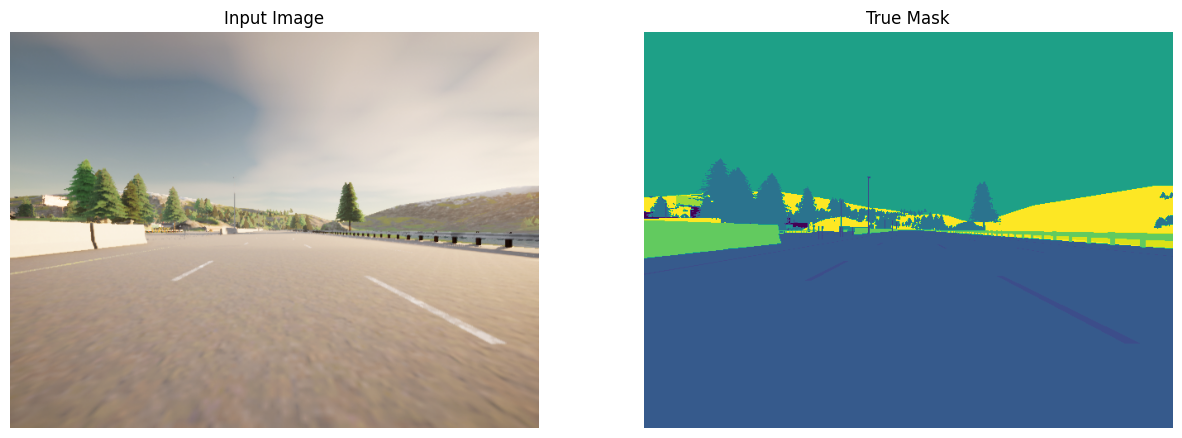

In [16]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


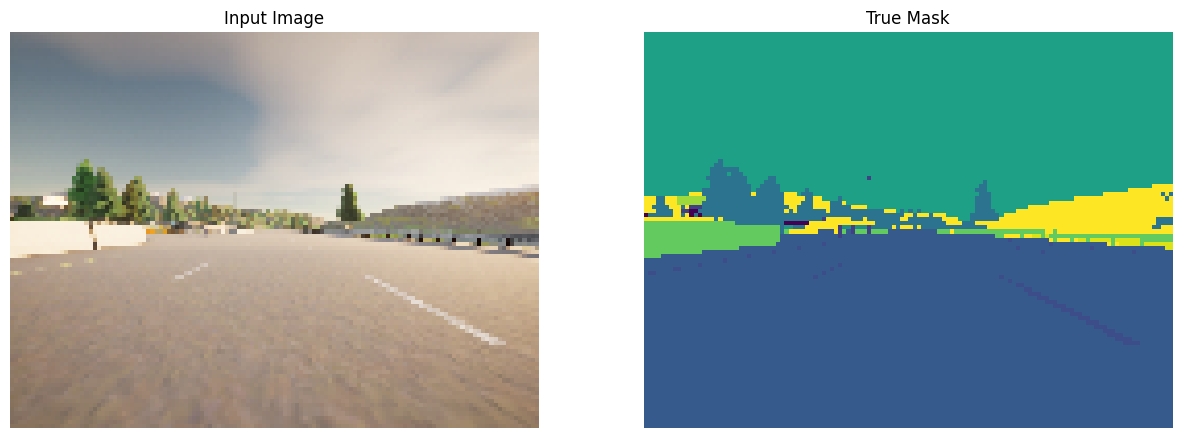

In [17]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

## 4 - Train the U-Net Model

In [18]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))


In [19]:
model_history = unet.fit(train_dataset, epochs=EPOCHS)

Epoch 1/5
34/34 [==============================] - 83s 2s/step - loss: 2.1911 - accuracy: 0.4156
Epoch 2/5
34/34 [==============================] - 80s 2s/step - loss: 0.9549 - accuracy: 0.7584
Epoch 3/5
34/34 [==============================] - 78s 2s/step - loss: 0.6690 - accuracy: 0.8156
Epoch 4/5
34/34 [==============================] - 79s 2s/step - loss: 0.5418 - accuracy: 0.8426
Epoch 5/5
34/34 [==============================] - 79s 2s/step - loss: 0.4847 - accuracy: 0.8672


<font color="red">Training on CPU is very slow! On GPU with 40 epochs, the results are amazing!</font>

### 4.1 - Create Predicted Masks

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

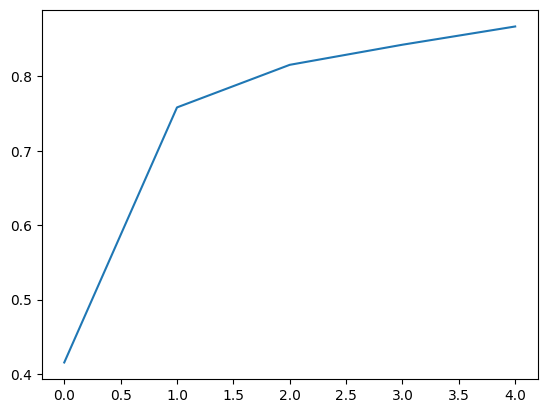

In [21]:
# Accuracy
plt.plot(model_history.history["accuracy"])

### 4.2 - Show Predictions

In [22]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 743ms/step


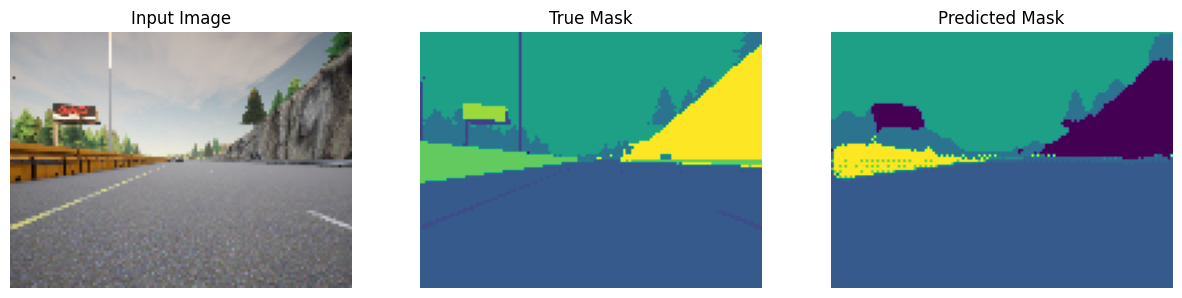

1/1 [==============================] - 0s 447ms/step


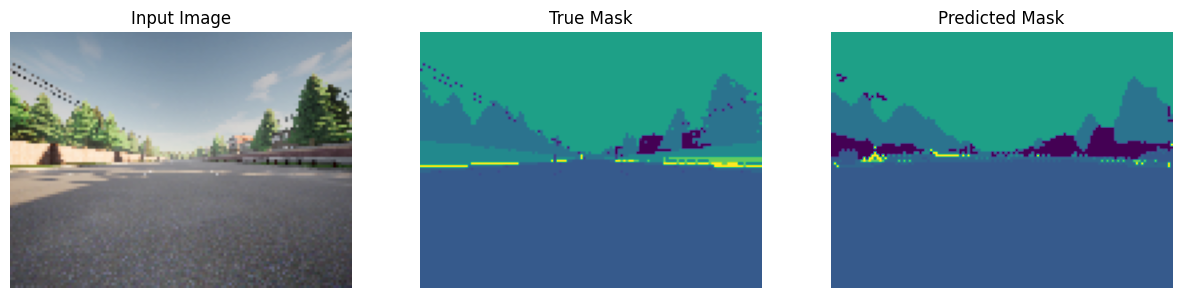

1/1 [==============================] - 1s 506ms/step


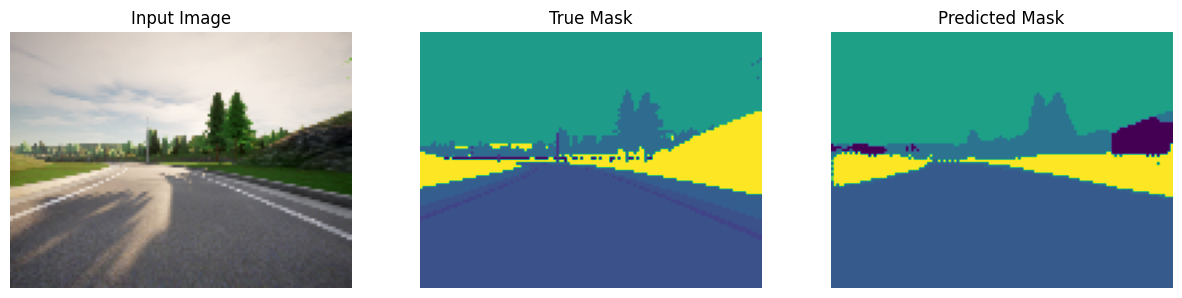

1/1 [==============================] - 1s 501ms/step


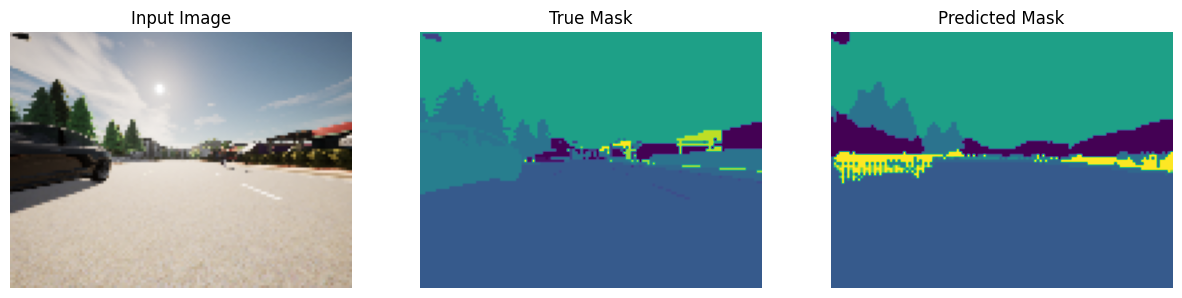

1/1 [==============================] - 0s 478ms/step


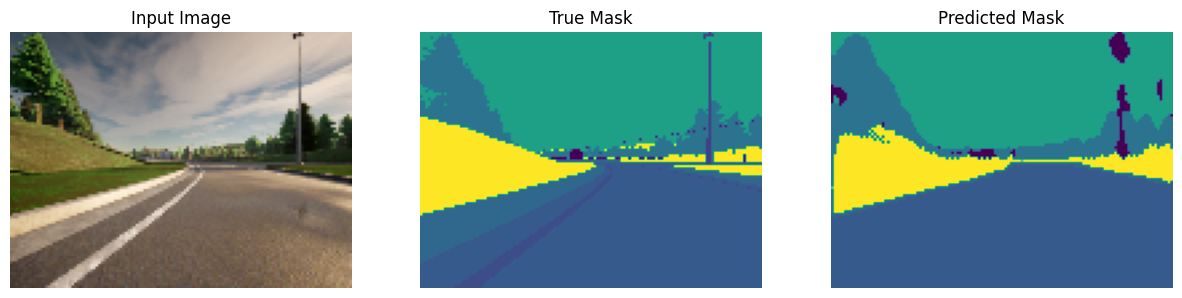

1/1 [==============================] - 1s 554ms/step


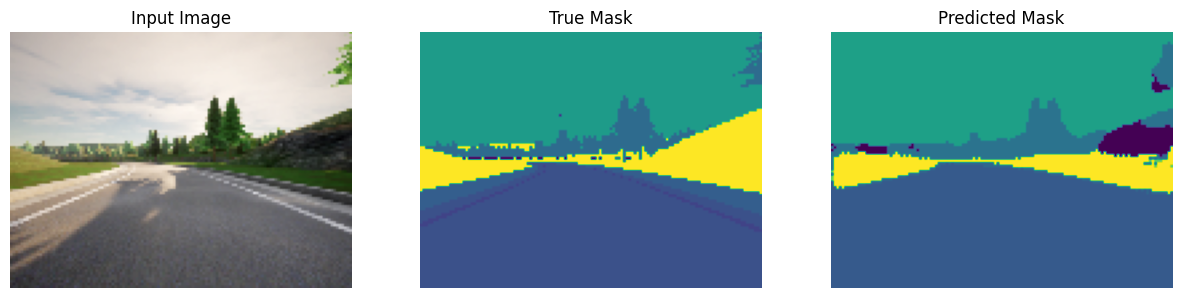

In [23]:
show_predictions(train_dataset, 6)